# Case Study 3 : Data Science in NYC Taxi and Uber Data

**Required Readings:** 
* [Analyzing 1.1 Billion NYC Taxi and Uber Trips](http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/) 
* Please download the NYC taxi and Uber dataset from [here](https://github.com/toddwschneider/nyc-taxi-data).
* [TED Talks](https://www.ted.com/talks) for examples of 7 minutes talks.


**NOTE**
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.


# Problem: pick a data science problem that you plan to solve using Uber/Taxi Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

# Data Collection/Processing: 

# Data Exploration: Exploring the Uber/Taxi Dataset

**plot the spatial distribution of the pickup locations of 5000 Uber trips** 
* collect a set of 5000 Uber trips
* plot the distribution of the pickup locations using a scatter plot figure.

In [17]:
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd
import numpy as np
import shapefile
from descartes import PolygonPatch
con = psycopg2.connect(database="nyc-taxi-data", user="postgres", password="Wpishare!", host="127.0.0.1", port="5432")
cur = con.cursor()

In [18]:
cur.execute("rollback;")
cur.execute("select distinct base_number from fhv_bases where dba_category='uber';")
uber_number = cur.fetchall()

These base_number are ubers.

In [19]:
# to give diction results, use: 
import psycopg2.extras
cur2 = con.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
cur2.execute("select * from fhv_trips where Dispatching_base_num in (select distinct base_number from fhv_bases where dba_category='uber') limit 5000;")
uber_5000 = cur2.fetchall()
#print(uber_5000)
# for uber data, there are pickup location_id but no dropoff locations
# the location_id is corresponding to the locationid in table "taxi_zones"
df = pd.DataFrame(uber_5000)
df.head()


id dispatching_base_num     pickup_datetime dropoff_datetime  \
0  843090               B02512 2015-01-11 02:00:42             None   
1  843091               B02512 2015-01-11 02:01:10             None   
2  843092               B02512 2015-01-11 02:01:15             None   
3  843093               B02512 2015-01-11 02:04:04             None   
4  843094               B02512 2015-01-11 02:04:55             None   

   pickup_location_id dropoff_location_id shared_ride hvfhs_license_num  
0                  79                None        None              None  
1                  48                None        None              None  
2                 171                None        None              None  
3                 261                None        None              None  
4                 158                None        None              None

Get the shapefile of taxi_zones

In [20]:
cur2.execute("select * from taxi_zones;")
taxi_zones = cur2.fetchmany(1)
#print(taxi_zones)

To get uber data in 2014 with pickup & dropoff, time & loc_id:

Directly use shpfile to plot the taxi zones and 5000 uber pickup records.

/home/wpishare/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


[-74.3, -73.6, 40.45, 40.95]

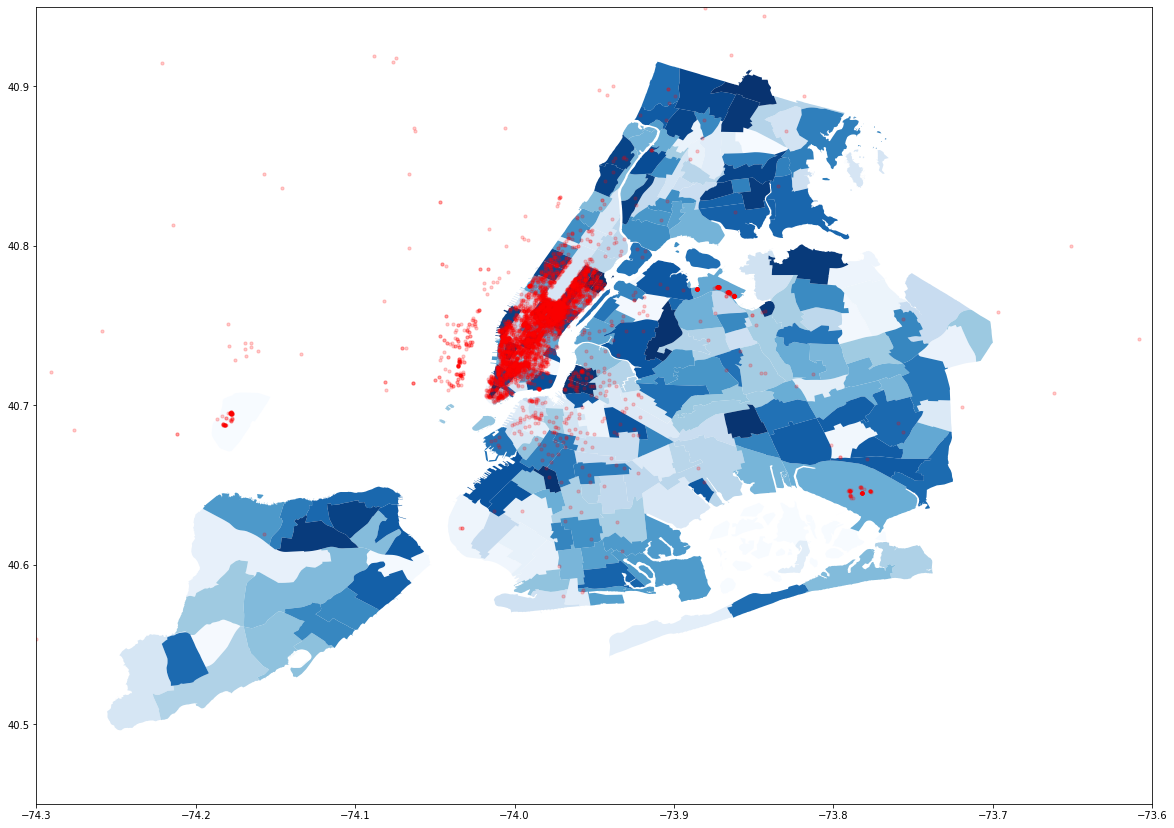

In [21]:
import geopandas as gpd
gdf = gpd.GeoDataFrame.from_file("data/case3/nyc-taxi-data/shapefiles/taxi_zones/taxi_zones.shp")
#gdf.crs #crs = 2263
gdf = gdf.to_crs(epsg=4326)  # reproject as 4326, lat/lon

cur2.execute("select * from uber_trips_2014 limit 5000;")
ub14 = cur2.fetchall()
ub14 = pd.DataFrame(ub14)
coor = ub14[["pickup_latitude","pickup_longitude"]]
coor.rename(columns={"pickup_latitude":"latitude", "pickup_longitude":"longitude"},inplace=True)
geometry = [Point(xy) for xy in zip(coor["longitude"],coor["latitude"])]
coor = gpd.GeoDataFrame(coor, crs=gdf.crs,geometry=geometry)
# 
plt.figure(figsize=(20,15))
ax = plt.gca()
gdf.plot(ax=ax,cmap='Blues')
coor.plot(ax=ax,markersize=10,color="red",alpha=0.2)
plt.axis([-74.3,-73.6,40.45,40.95])


# The Solution: implement a data science solution to the problem you are trying to solve.

## Geospatial: top pickups and transitions

In [22]:
zone_count = df.groupby("pickup_location_id").size()
#zone_count

There are 4534327 records in this table.

In [23]:
cur2.execute("select * from uber_trips_2014 limit 100000;")
ub_ = cur2.fetchall()
ub_ = pd.DataFrame(ub_)
ub_.head(5)

id     pickup_datetime pickup_latitude pickup_longitude base_code
0   1 2014-04-01 00:11:00          40.769         -73.9549    B02512
1   2 2014-04-01 00:17:00         40.7267         -74.0345    B02512
2   3 2014-04-01 00:21:00         40.7316         -73.9873    B02512
3   4 2014-04-01 00:28:00         40.7588         -73.9776    B02512
4   5 2014-04-01 00:33:00         40.7594         -73.9722    B02512

In [24]:
geom = [Point(xy) for xy in zip(ub_["pickup_longitude"],ub_["pickup_latitude"])]
ub_ = gpd.GeoDataFrame(ub_, crs=gdf.crs,geometry=geom)

In [25]:
# We're going to keep a list of how many points we find.
pts_in_polys = []
pts = ub_.copy() 
# Loop over polygons with index i.
tmp = 0
for i, poly in gdf.iterrows():
    tmp +=1
    print("process:%d/200"%tmp)
    # Keep a list of points in this poly
    pts_in_this_poly = []

    # Now loop over all points with index j.
    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            # Then it's a hit! Add it to the list,
            # and drop it so we have less hunting.
            pts_in_this_poly.append(pt.geometry)
            pts = pts.drop([j])

    # We could do all sorts, like grab a property of the
    # points, but let's just append the number of them.
    pts_in_polys.append(len(pts_in_this_poly))

# Add the number of points for each poly to the dataframe.
gdf['number of points'] = gpd.GeoSeries(pts_in_polys)

process:1/200
process:2/200
process:3/200
process:4/200
process:5/200
process:6/200
process:7/200
process:8/200
process:9/200
process:10/200
process:11/200
process:12/200
process:13/200
process:14/200
process:15/200
process:16/200
process:17/200
process:18/200
process:19/200
process:20/200
process:21/200
process:22/200
process:23/200
process:24/200
process:25/200
process:26/200
process:27/200
process:28/200
process:29/200
process:30/200
process:31/200
process:32/200
process:33/200
process:34/200
process:35/200
process:36/200
process:37/200
process:38/200
process:39/200
process:40/200
process:41/200
process:42/200
process:43/200
process:44/200
process:45/200
process:46/200
process:47/200
process:48/200
process:49/200
process:50/200
process:51/200
process:52/200
process:53/200
process:54/200
process:55/200
process:56/200
process:57/200
process:58/200
process:59/200
process:60/200
process:61/200
process:62/200
process:63/200
process:64/200
process:65/200
process:66/200
process:67/200
proc

/home/wpishare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.


/home/wpishare/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:459: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


[-74.2, -73.7, 40.55, 40.9]

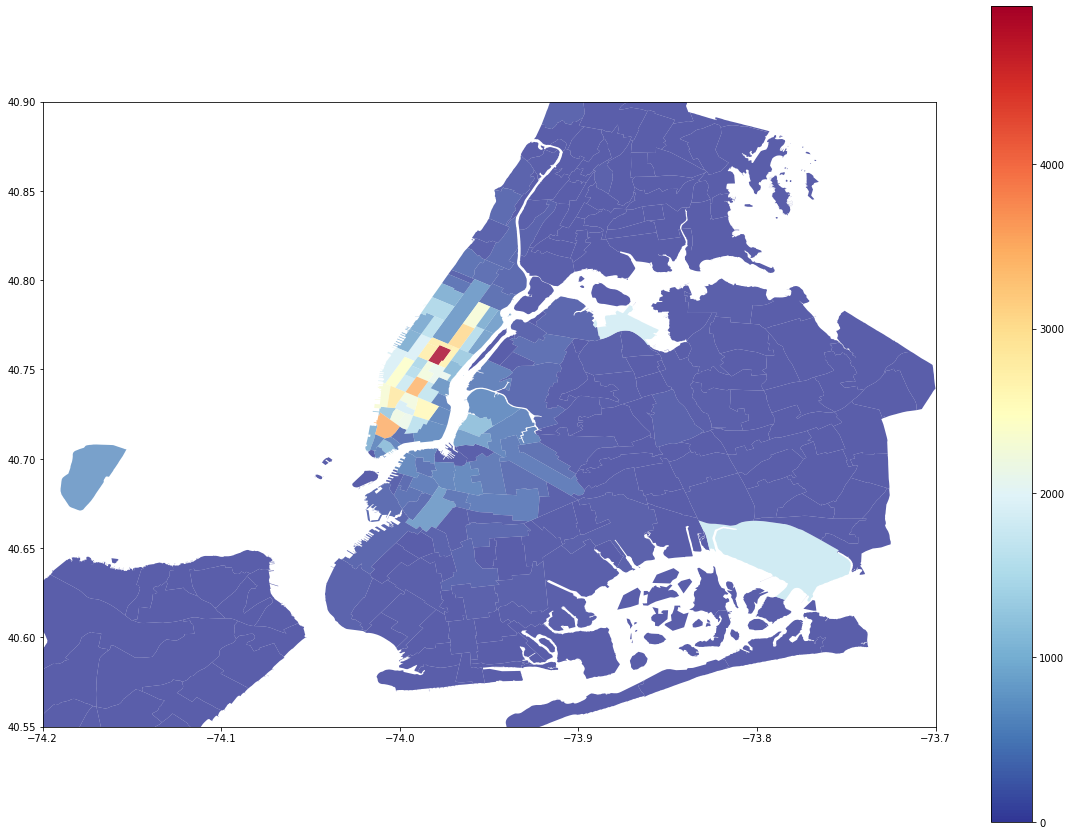

In [26]:
plt.figure(figsize=(20,15))
ax = plt.gca()
gdf.plot(ax=ax,column='number of points',colormap="RdYlBu_r",alpha=0.8,legend=True)
#coor.plot(ax=ax,markersize=10,color="red",alpha=0.2)
plt.axis([-74.2,-73.7,40.55,40.9])

In [27]:
dflarge = pd.read_csv("/home/wpishare/has_datetime_trip.csv",nrows=100000,skiprows=350000000,header=None,infer_datetime_format=True)

dflarge.columns = ["id","cab_type_id","pickup_datetime","dropoff_datetime","store_and_fwd_flag","pickup_lon","pickup_lat","dropoff_lon","dropoff_lat","trip_dist","trip_type","pickup_loc_id","dropoff_loc_id", 'passenger_count']
dflarge.head(5)

id  cab_type_id      pickup_datetime     dropoff_datetime  \
0  355706761            1  2010-08-31 23:58:24  2010-09-01 00:21:34   
1  355706762            1  2010-08-08 04:04:00  2010-08-08 04:15:00   
2  355706763            1  2010-08-07 11:40:34  2010-08-07 12:01:29   
3  355706764            1  2010-08-06 17:36:44  2010-08-06 17:42:18   
4  355706765            1  2010-08-27 15:04:00  2010-08-27 15:17:00   

  store_and_fwd_flag  pickup_lon  pickup_lat  dropoff_lon  dropoff_lat  \
0                  N  -73.987608   40.757677   -74.002018    40.724710   
1                NaN  -73.982343   40.771728   -74.002735    40.727263   
2                  N  -73.975389   40.751193   -74.000918    40.724960   
3                  N  -73.989102   40.729327   -74.001362    40.724737   
4                NaN  -73.997997   40.740902   -74.000278    40.723733   

   trip_dist  trip_type  pickup_loc_id  dropoff_loc_id  passenger_count  
0       5.80        NaN          230.0           211.0                1  
1       3.93        NaN          142.0           211.0                1  
2       3.40        NaN          162.0           211.0                1  
3       0.90        NaN           79.0           211.0                1  
4       1.45        NaN           90.0           211.0                1

In [28]:
zone_count_taxi=dflarge.groupby("pickup_loc_id")["id"].count()
zone_count_taxi = zone_count_taxi.to_frame()
zone_count_taxi.reset_index(inplace=True)
zone_count_taxi.rename(columns={"id":"taxi_count"})

pickup_loc_id  taxi_count
0              1.0          14
1              2.0           1
2              4.0         391
3              7.0         248
4              8.0           2
5              9.0           5
6             10.0          13
7             12.0          58
8             13.0         775
9             14.0          10
10            15.0           2
11            16.0           1
12            17.0          21
13            18.0           1
14            19.0           1
15            20.0           4
16            21.0           5
17            22.0          11
18            23.0           2
19            24.0         233
20            25.0         142
21            26.0          11
22            27.0           1
23            28.0          15
24            29.0           2
25            31.0           1
26            32.0           1
27            33.0         169
28            34.0           4
29            35.0           3
..             ...         ...
196          231.0        2051
197          232.0         258
198          233.0        1481
199          234.0        3252
200          235.0           8
201          236.0        2604
202          237.0        3165
203          238.0        1411
204          239.0        2062
205          240.0           3
206          241.0           2
207          242.0           6
208          243.0          12
209          244.0          78
210          246.0        1440
211          247.0          15
212          248.0           2
213          249.0        2340
214          250.0           6
215          251.0           1
216          252.0           4
217          254.0           1
218          255.0         246
219          256.0         192
220          257.0           5
221          258.0           2
222          260.0          91
223          261.0         465
224          262.0         956
225          263.0        1486

[226 rows x 2 columns]

In [29]:
temp = gdf.merge(pd.DataFrame(zone_count_taxi),left_on="LocationID",right_on="pickup_loc_id")
temp.rename(columns = {"id":"count_taxi"},inplace=True)


/home/wpishare/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:459: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


[-74.2, -73.7, 40.55, 40.9]

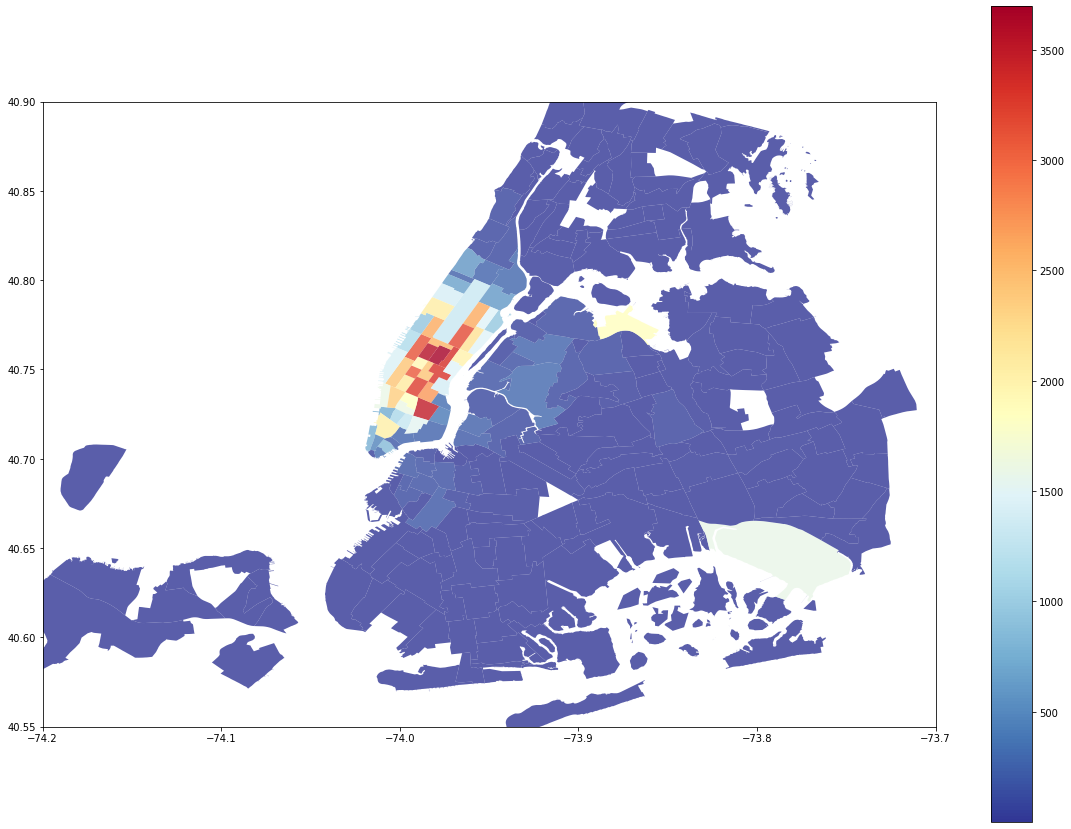

In [31]:
plt.figure(figsize=(20,15))
ax = plt.gca()
temp.plot(ax=ax,column='count_taxi',colormap="RdYlBu_r",alpha=0.8,legend=True)
#coor.plot(ax=ax,markersize=10,color="red",alpha=0.2)
plt.axis([-74.2,-73.7,40.55,40.9])

/home/wpishare/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:459: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


[-74.2, -73.7, 40.55, 40.9]

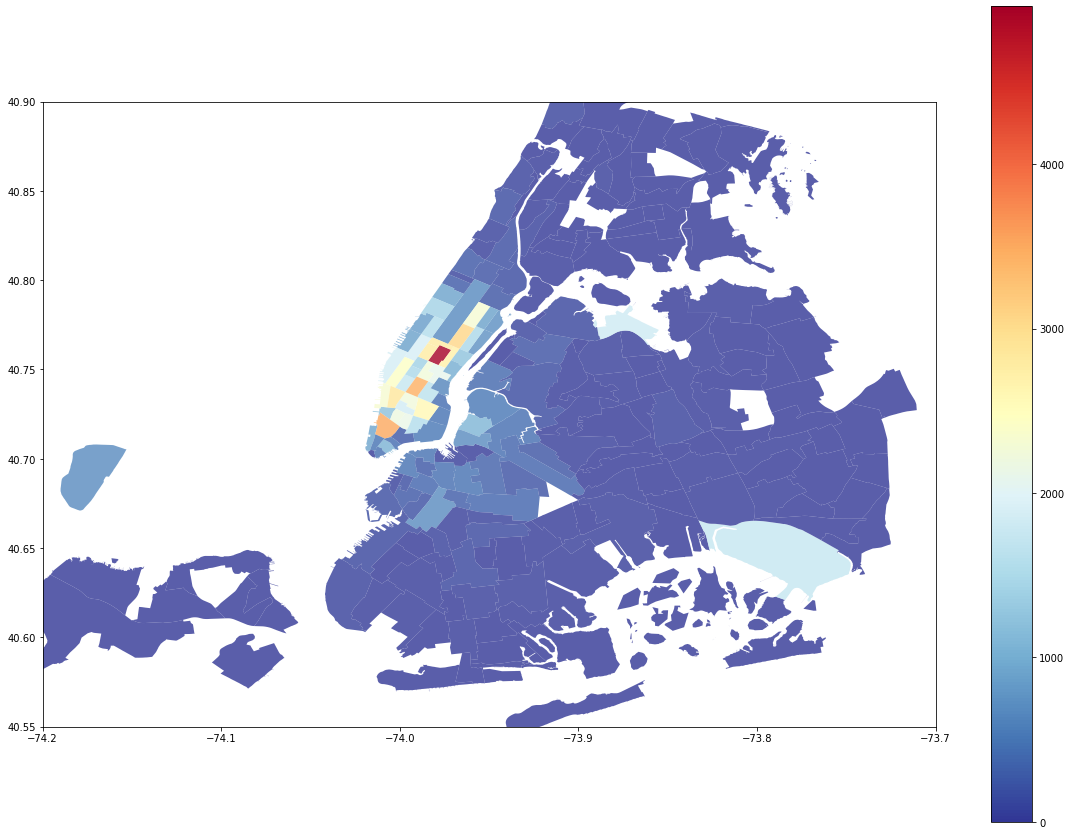

In [16]:
plt.figure(figsize=(20,15))
ax = plt.gca()
temp.plot(ax=ax,column='number of points',colormap="RdYlBu_r",alpha=0.8,legend=True)
#coor.plot(ax=ax,markersize=10,color="red",alpha=0.2)
plt.axis([-74.2,-73.7,40.55,40.9])

This "center" is the centroid of each polygon

In [32]:
center = gdf["geometry"].centroid
center.head(1)

0    POINT (-74.17400 40.69183)
dtype: geometry

In [44]:
taxi_tran = pd.read_csv("/home/wpishare/has_datetime_trip.csv",nrows=5000000,skiprows=300000000,header=None,infer_datetime_format=True)

taxi_tran.columns = ["id","cab_type_id","pickup_datetime","dropoff_datetime","store_and_fwd_flag","pickup_lon","pickup_lat","dropoff_lon","dropoff_lat","trip_dist","trip_type","pickup_loc_id","dropoff_loc_id", 'passenger_count']
#taxi_tran.head(5)
trans = np.zeros((263,263))
for row in taxi_tran.itertuples():
    if not np.isnan((row[-3])) and not np.isnan((row[-2])):
        i = int(row[-3]-1)
        j = int(row[-2]-1)
        trans[i][j] += 1

In [45]:
#the row index is pickup zone, the col index is dropoff zone.
trans.sum()

4841860.0

In [47]:
temp.sort_values(by="count_taxi",ascending=False,inplace=True)
rank = temp[["LocationID","borough","zone","count_taxi"]]
rank[1:10]

LocationID    borough                          zone  count_taxi
196         230  Manhattan     Times Sq/Theatre District        3571
68           79  Manhattan                  East Village        3484
137         162  Manhattan                  Midtown East        3340
145         170  Manhattan                   Murray Hill        3316
200         234  Manhattan                      Union Sq        3252
203         237  Manhattan         Upper East Side South        3165
41           48  Manhattan                  Clinton East        3126
156         186  Manhattan  Penn Station/Madison Sq West        3081
89          107  Manhattan                      Gramercy        2715

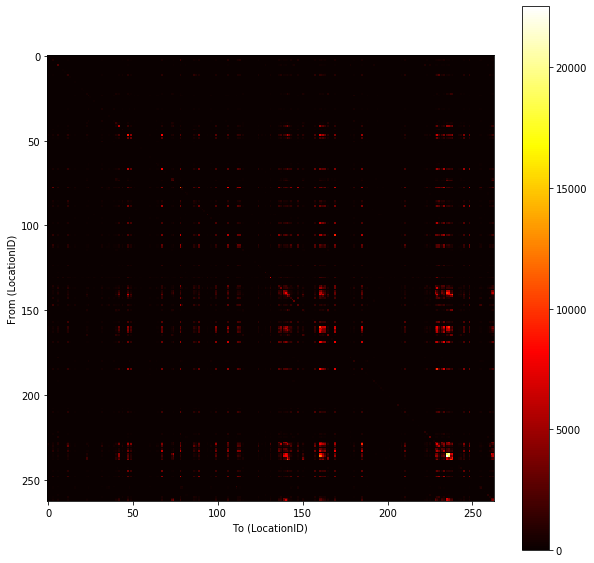

In [48]:
plt.figure(figsize=(10,10))
ax=plt.gca()
im = ax.imshow(trans, cmap=plt.cm.hot)
plt.colorbar(im)
plt.xlabel("To (LocationID)")
plt.ylabel("From (LocationID)")
plt.show()

In [49]:
rank = rank.merge(pd.DataFrame(center),left_index=True, right_index=True)
#rank.head()
rank.rename(columns={0:"centroid"},inplace=True)

In [50]:
topten = list(rank["LocationID"][0:10])

/home/wpishare/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:459: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


[-74.2, -73.7, 40.55, 40.9]

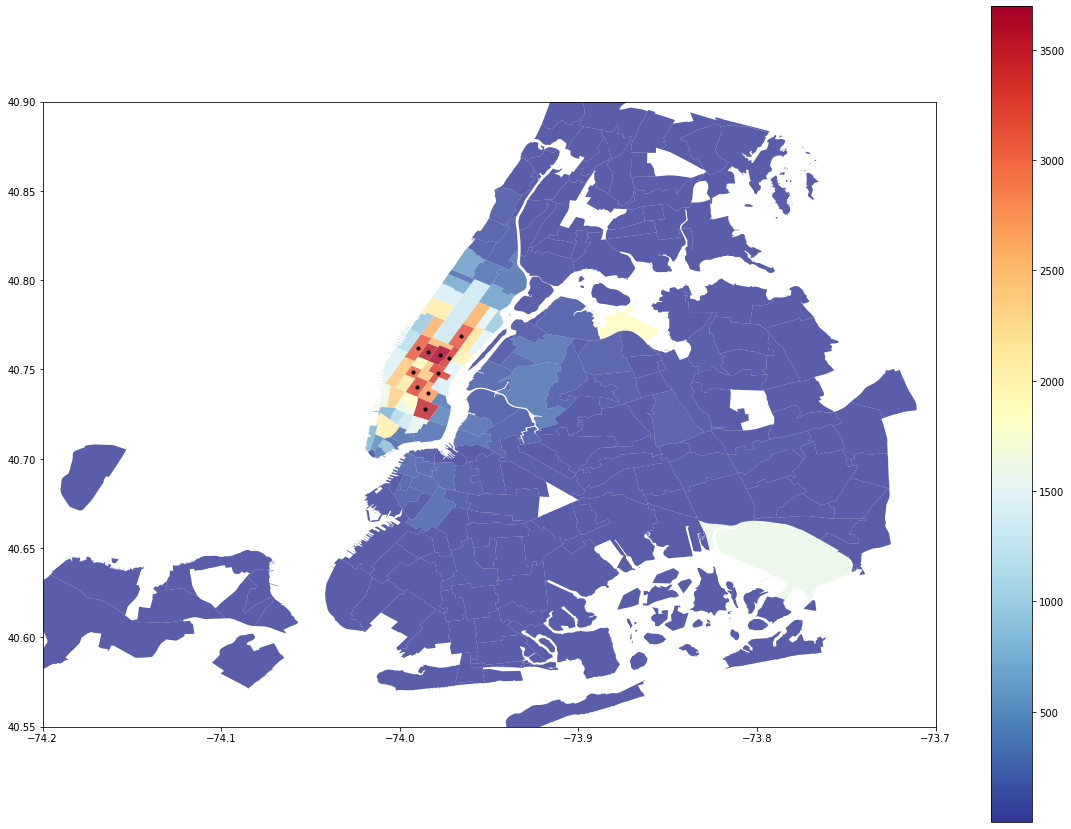

In [51]:
plt.figure(figsize=(20,15))
ax = plt.gca()
temp.plot(ax=ax,column='count_taxi',colormap="RdYlBu_r",alpha=0.8,legend=True)
#point10 = center.iloc[]
for i in range(0,10):
    topten[i] -= 1
center[topten].plot(ax=ax,markersize=10,color="black",alpha=0.9)

plt.axis([-74.2,-73.7,40.55,40.9])  

#     plt.plot(x[i], y[i], color='r')
#     plt.scatter(x[i], y[i], color='b')

In [64]:
#topten zone index is adjusted to 0-based
def plot_trans_lines(order):
    #plt.figure(figsize=(25,10))
    #ax = plt.gca()
    #first = topten[0]
    #temp.plot(ax=ax,column='count_taxi',colormap="RdYlBu_r",alpha=0.3)
    center[topten].plot(ax=ax,markersize=10,color="black",alpha=0.9)
    from_sum = sum(trans[order])
    to_sum = sum(trans[:][order])
    from_lines = gpd.GeoDataFrame(columns=['start_id','end_id','line','value','percentage'], 
                geometry='line') 
    to_lines = gpd.GeoDataFrame(columns=['start_id','end_id','line','value','percentage'], 
                geometry='line') 
    for i in range(0, 263):
        if i == order or trans[order][i]<0.02*from_sum:
            continue
        else: 
            li = LineString([[center[order].x, center[order].y], [center[i].x, center[i].y]])
            from_lines=from_lines.append({'start_id':order+1, 'end_id':i+1, 'line':li, 'value':trans[order][i],'percentage':trans[order][i]/from_sum},ignore_index=True)
    for i in range(0, 263):
        if i == order or trans[i][order]<0.02*to_sum:
            continue
        else: 
            li = LineString([[center[order].x, center[order].y], [center[i].x, center[i].y]])
            to_lines=to_lines.append({'start_id':i+1, 'end_id':order+1, 'line':li, 'value':trans[i][order],'percentage':trans[i][order]/to_sum},ignore_index=True)
    plt.figure(figsize=(30,15),dpi=500)
    ax1 = plt.subplot(121)
    temp.plot(ax=ax1,column='count_taxi',cmap="RdYlBu_r",alpha=0.3)
    center[topten].plot(ax=ax1,markersize=10,color="black",alpha=0.9)
    from_lines.plot(ax=ax1,linewidth=5, column = 'percentage',cmap = 'RdYlBu_r',legend = True)
    plt.title("From %s ..."%(rank[rank['LocationID'] == order+1]['zone'].values[0]))
    plt.axis([-74.01,-73.87,40.7,40.82])
    ax2 = plt.subplot(122, sharex=ax1,sharey=ax1)
    temp.plot(ax=ax2,column='count_taxi',cmap="RdYlBu_r",alpha=0.3)
    center[topten].plot(ax=ax2,markersize=10,color="black",alpha=0.9)
    to_lines.plot(ax=ax2, linewidth=5, column = 'percentage',cmap = 'RdYlBu_r',legend = True)
    #plt.axis([-74.05,-73.92,40.7,40.82])
    plt.title("To %s ..."%(rank[rank['LocationID'] == order+1]['zone'].values[0]))
    return from_lines, to_lines
from_lines, to_lines = plot_trans_lines(topten[0])       

<Figure size 432x288 with 0 Axes>

In [60]:
from_lines = from_lines.merge(rank[["LocationID","zone"]],left_on="end_id",right_on="LocationID")
to_lines = to_lines.merge(rank[["LocationID","zone"]],left_on="start_id",right_on="LocationID")

In [61]:
from_lines[["end_id","zone","value","percentage"]].sort_values(by='percentage',ascending=False)

end_id                          zone   value  percentage
14    237         Upper East Side South  9874.0    0.056268
11    230     Times Sq/Theatre District  7768.0    0.044267
13    236         Upper East Side North  7494.0    0.042705
12    234                      Union Sq  7482.0    0.042637
8     164                 Midtown South  7068.0    0.040278
10    186  Penn Station/Madison Sq West  6720.0    0.038295
7     163                 Midtown North  6487.0    0.036967
9     170                   Murray Hill  6475.0    0.036899
6     162                  Midtown East  5690.0    0.032425
5     142           Lincoln Square East  5217.0    0.029730
4     141               Lenox Hill West  4637.0    0.026425
0      48                  Clinton East  4520.0    0.025758
1     100              Garment District  4490.0    0.025587
3     138             LaGuardia Airport  4059.0    0.023131
2     107                      Gramercy  3611.0    0.020578

In [57]:
to_lines[["start_id","zone","value","percentage"]].sort_values(by='percentage',ascending=False)

start_id                           zone    value  percentage
19      237          Upper East Side South  12467.0    0.071045
18      236          Upper East Side North   8767.0    0.049960
13      186   Penn Station/Madison Sq West   8621.0    0.049128
12      170                    Murray Hill   8313.0    0.047373
15      230      Times Sq/Theatre District   7823.0    0.044580
10      163                  Midtown North   7647.0    0.043577
1        48                   Clinton East   7267.0    0.041412
11      164                  Midtown South   7260.0    0.041372
8       142            Lincoln Square East   7246.0    0.041292
17      234                       Union Sq   7172.0    0.040871
9       162                   Midtown East   6542.0    0.037280
3       100               Garment District   6004.0    0.034215
7       141                Lenox Hill West   5652.0    0.032209
4       107                       Gramercy   5099.0    0.029057
0        43                   Central Park   4868.0    0.027741
5       138              LaGuardia Airport   4845.0    0.027610
14      229  Sutton Place/Turtle Bay North   4827.0    0.027507
20      239          Upper West Side South   3898.0    0.022213
2        68                   East Chelsea   3817.0    0.021752
16      233            UN/Turtle Bay South   3562.0    0.020298
6       140                Lenox Hill East   3521.0    0.020065

In [65]:
from_lines, to_lines = plot_trans_lines(topten[1])       

<Figure size 432x288 with 0 Axes>

## The Solution: implement a data science solution to the problem you are trying to solve.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm._tqdm_notebook as tqdm

%matplotlib inline

### Prep

#### Load and Overview

In [2]:
cols = ['id', 
        'cab_type_id', 
        'pickup_datetime', 
        'dropoff_datetime', 
        'store_and_fwd_flag', 
        'pickup_longitude', 
        'pickup_latitude', 
        'dropoff_longitude', 
        'dropoff_latitude', 
        'trip_distance', 
        'trip_type', 
        'pickup_location_id', 
        'dropoff_location_id',
        'passenger_count']
taxi_tran = pd.read_csv("/home/wpishare/has_datetime_trip.csv",
                        skiprows=lambda i: i % 320 != 0,         # read 1 data every 320
                        header=None,
                        infer_datetime_format=True,
                        names=cols)

/home/wpishare/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
taxi_tran.head()

id  cab_type_id      pickup_datetime     dropoff_datetime  \
0  5706821            2  2014-05-02 20:08:46  2014-05-02 20:13:14   
1  5707141            2  2014-05-02 20:13:53  2014-05-02 20:18:50   
2  5707461            2  2014-05-02 20:18:47  2014-05-02 20:23:49   
3  5707781            2  2014-05-02 20:23:47  2014-05-02 20:24:05   
4  5708101            2  2014-05-02 20:29:01  2014-05-02 20:37:54   

  store_and_fwd_flag  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                  N        -73.957932        40.717602         -73.959625   
1                  N        -73.944954        40.720234         -73.958679   
2                  N        -73.950912        40.724209         -73.961563   
3                  N        -73.949135        40.714073         -73.937637   
4                  N        -73.913078        40.850117         -73.919540   

   dropoff_latitude  trip_distance  trip_type  pickup_location_id  \
0         40.711266           0.59        1.0               255.0   
1         40.698154           1.80        1.0               112.0   
2         40.716358           1.10        1.0               112.0   
3         40.758263           0.00        1.0                80.0   
4         40.860603           1.76        1.0               235.0   

   dropoff_location_id  passenger_count  
0                256.0                1  
1                 17.0                3  
2                255.0                1  
3                146.0                2  
4                127.0                1

In [4]:
taxi_tran.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150555 entries, 0 to 5150554
Data columns (total 14 columns):
id                     5150555 non-null int64
cab_type_id            5150555 non-null int64
pickup_datetime        5150555 non-null object
dropoff_datetime       5150555 non-null object
store_and_fwd_flag     3470770 non-null object
pickup_longitude       3972464 non-null float64
pickup_latitude        3972666 non-null float64
dropoff_longitude      3972892 non-null float64
dropoff_latitude       3973090 non-null float64
trip_distance          5150555 non-null float64
trip_type              229861 non-null float64
pickup_location_id     5061799 non-null float64
dropoff_location_id    5056842 non-null float64
passenger_count        5150555 non-null int64
dtypes: float64(8), int64(3), object(3)
memory usage: 550.1+ MB


drop not useful features

In [5]:
taxi_tran_drop = taxi_tran.drop(columns=['id', 'trip_type', 'pickup_location_id', 'dropoff_location_id'])

In [6]:
taxi_tran_drop['pickup_datetime'] = taxi_tran_drop['pickup_datetime'].astype('datetime64[ns]')
taxi_tran_drop['dropoff_datetime'] = taxi_tran_drop['dropoff_datetime'].astype('datetime64[ns]')
taxi_tran_drop['duration'] = ((taxi_tran_drop['dropoff_datetime'] - taxi_tran_drop['pickup_datetime'])
                              .dt.seconds)

#### Cleaning

##### deal with store_and_fwd_flag

In [7]:
count = taxi_tran_drop[['pickup_datetime', 'store_and_fwd_flag']].groupby('store_and_fwd_flag').agg('count').rename({'pickup_datetime': 'count'}, axis=1)
count.head()

count
store_and_fwd_flag         
0.0                  341325
1.0                    6223
0                      7094
1                        94
N                   3080478

In [8]:
taxi_tran_drop['store_and_fwd_flag'].replace({0.0:'N', 
                                              0: 'N', 
                                              '0': 'N',
                                              '0.0': 'N',
                                              1.0: 'Y',
                                              1: 'Y',
                                              '1': 'Y',
                                              '1.0': 'Y'},
                                            inplace=True)

##### deal with na

In [9]:
count = taxi_tran_drop[['pickup_datetime', 'store_and_fwd_flag']].groupby('store_and_fwd_flag').agg('count').rename({'pickup_datetime': 'count'}, axis=1)
count.head()

count
store_and_fwd_flag         
N                   3428897
Y                     41873

In [10]:
common = count.sort_values(by='count', ascending=False).iloc[0, :].name

fill with 0? convert to dummy variable, and na -> store_and_fwd_flag_0.0:0, store_and_fwd_flag_1.0:0?

##### outlier

In [11]:
taxi_tran_drop.describe()

cab_type_id  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  5.150555e+06      3.972464e+06     3.972666e+06       3.972892e+06   
mean   1.046423e+00     -7.392342e+01     4.070156e+01      -7.392288e+01   
std    2.103993e-01      6.792827e+00     7.343036e+00       6.200744e+00   
min    1.000000e+00     -3.442026e+03    -3.490866e+03      -3.356670e+03   
25%    1.000000e+00     -7.399192e+01     4.073583e+01      -7.399134e+01   
50%    1.000000e+00     -7.398159e+01     4.075329e+01      -7.397995e+01   
75%    1.000000e+00     -7.396638e+01     4.076803e+01      -7.396319e+01   
max    2.000000e+00      3.438057e+03     3.364024e+03       3.459030e+03   

       dropoff_latitude  trip_distance  passenger_count      duration  
count      3.973090e+06   5.150555e+06     5.150555e+06  5.150555e+06  
mean       4.070293e+01   6.955101e+00     1.655187e+00  8.556005e+02  
std        5.976420e+00   5.993201e+03     1.312548e+00  2.535999e+03  
min       -3.084279e+03   0.000000e+00     0.000000e+00  0.000000e+00  
25%        4.073489e+01   1.000000e+00     1.000000e+00  3.740000e+02  
50%        4.075382e+01   1.720000e+00     1.000000e+00  6.220000e+02  
75%        4.076881e+01   3.180000e+00     2.000000e+00  1.006000e+03  
max        3.364024e+03   1.200000e+07     2.080000e+02  8.639900e+04

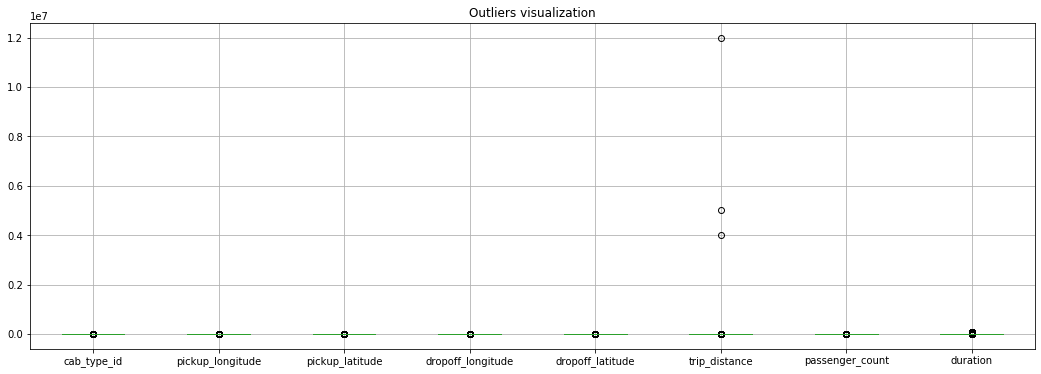

In [12]:
plt.subplots(figsize=(18,6))
plt.title("Outliers visualization")
taxi_tran_drop.boxplot();

Note that the coordinates of NY is about 40° N, 74° W, so there are some outliers maybe relate to typo or long travels. They might hurt the model so we should delete them.

In [13]:
taxi_tran_drop = taxi_tran_drop[(taxi_tran_drop['pickup_longitude'] > -79) & 
                                (taxi_tran_drop['pickup_longitude'] < -69) & 
                                (taxi_tran_drop['dropoff_longitude'] > -79) &
                                (taxi_tran_drop['dropoff_longitude'] < -69) & 
                                (taxi_tran_drop['pickup_latitude'] > 35) &
                                (taxi_tran_drop['pickup_latitude'] < 45) & 
                                (taxi_tran_drop['dropoff_latitude'] > 35) &
                                (taxi_tran_drop['dropoff_latitude'] < 45) &
                                (taxi_tran_drop['duration'] != 0) &
                                (taxi_tran_drop['duration'] < taxi_tran_drop['duration'].quantile(0.95))]

In [14]:
taxi_tran_drop.describe()

cab_type_id  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  3.784492e+06      3.784492e+06     3.784492e+06       3.784492e+06   
mean   1.035234e+00     -7.397593e+01     4.075184e+01      -7.397413e+01   
std    1.843702e-01      3.852234e-02     3.336022e-02       3.905404e-02   
min    1.000000e+00     -7.880278e+01     3.519302e+01      -7.894563e+01   
25%    1.000000e+00     -7.399206e+01     4.073661e+01      -7.399139e+01   
50%    1.000000e+00     -7.398186e+01     4.075345e+01      -7.398015e+01   
75%    1.000000e+00     -7.396741e+01     4.076793e+01      -7.396404e+01   
max    2.000000e+00     -6.915315e+01     4.486088e+01      -6.919185e+01   

       dropoff_latitude  trip_distance  passenger_count      duration  
count      3.784492e+06   3.784492e+06     3.784492e+06  3.784492e+06  
mean       4.075221e+01   3.509474e+00     1.669296e+00  6.782625e+02  
std        3.609350e-02   2.056162e+03     1.300828e+00  4.029923e+02  
min        3.519312e+01   0.000000e+00     0.000000e+00  1.000000e+00  
25%        4.073599e+01   1.000000e+00     1.000000e+00  3.600000e+02  
50%        4.075413e+01   1.700000e+00     1.000000e+00  6.000000e+02  
75%        4.076902e+01   2.900000e+00     2.000000e+00  9.030000e+02  
max        4.423084e+01   4.000010e+06     9.000000e+00  1.919000e+03

In [15]:
taxi_tran_drop.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3784492 entries, 0 to 5150554
Data columns (total 11 columns):
cab_type_id           3784492 non-null int64
pickup_datetime       3784492 non-null datetime64[ns]
dropoff_datetime      3784492 non-null datetime64[ns]
store_and_fwd_flag    2216807 non-null object
pickup_longitude      3784492 non-null float64
pickup_latitude       3784492 non-null float64
dropoff_longitude     3784492 non-null float64
dropoff_latitude      3784492 non-null float64
trip_distance         3784492 non-null float64
passenger_count       3784492 non-null int64
duration              3784492 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(3), object(1)
memory usage: 346.5+ MB


#### feature engineering

##### target

Visualize the distribution of trip_duration values

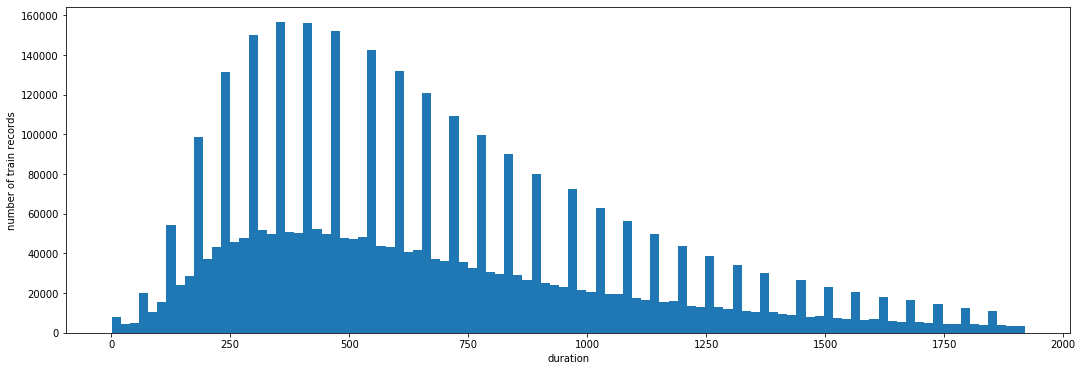

In [16]:
plt.subplots(figsize=(18,6))
plt.hist(taxi_tran_drop['duration'].values, bins=100)
plt.xlabel('duration')
plt.ylabel('number of train records')
plt.show()

Interesting figure, some routine trips might exists.

Right-skewed data, maybe log transformation is helpful.

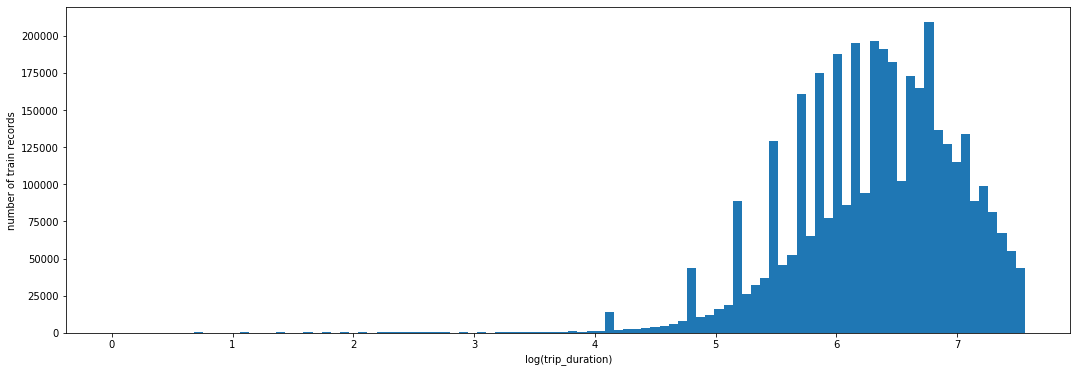

In [17]:
plt.subplots(figsize=(18,6))
taxi_tran_drop['log_duration'] = np.log(taxi_tran_drop['duration'].values)
plt.hist(taxi_tran_drop['log_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

##### categorical

In [18]:
#One-hot encoding binary categorical features
taxi_tran_drop = pd.concat([taxi_tran_drop, pd.get_dummies(taxi_tran_drop['cab_type_id'], prefix='cab_type_id')], axis=1)
taxi_tran_drop.drop(['cab_type_id'], axis=1, inplace=True)

taxi_tran_drop = pd.concat([taxi_tran_drop, pd.get_dummies(taxi_tran_drop['store_and_fwd_flag'], prefix='store_and_fwd_flag')], axis=1)
taxi_tran_drop.drop(['store_and_fwd_flag'], axis=1, inplace=True)

##### times

In [19]:
taxi_tran_drop['pickup_month'] = taxi_tran_drop['pickup_datetime'].dt.month
taxi_tran_drop['pickup_week'] = taxi_tran_drop['pickup_datetime'].dt.week
taxi_tran_drop['pickup_weekday'] = taxi_tran_drop['pickup_datetime'].dt.weekday
taxi_tran_drop['pickup_hour'] = taxi_tran_drop['pickup_datetime'].dt.hour
taxi_tran_drop['pickup_minute'] = taxi_tran_drop['pickup_datetime'].dt.minute
taxi_tran_drop['pickup_minute_oftheday'] = taxi_tran_drop['pickup_hour'] * 60 + taxi_tran_drop['pickup_minute']
taxi_tran_drop.drop(['pickup_minute', 'pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)


In [20]:
taxi_tran_drop.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.957932        40.717602         -73.959625         40.711266   
1        -73.944954        40.720234         -73.958679         40.698154   
2        -73.950912        40.724209         -73.961563         40.716358   
3        -73.949135        40.714073         -73.937637         40.758263   
4        -73.913078        40.850117         -73.919540         40.860603   

   trip_distance  passenger_count  duration  log_duration  cab_type_id_1  \
0           0.59                1       268      5.590987              0   
1           1.80                3       297      5.693732              0   
2           1.10                1       302      5.710427              0   
3           0.00                2        18      2.890372              0   
4           1.76                1       533      6.278521              0   

   cab_type_id_2  store_and_fwd_flag_N  store_and_fwd_flag_Y  pickup_month  \
0              1                     1                     0             5   
1              1                     1                     0             5   
2              1                     1                     0             5   
3              1                     1                     0             5   
4              1                     1                     0             5   

   pickup_week  pickup_weekday  pickup_hour  pickup_minute_oftheday  
0           18               4           20                    1208  
1           18               4           20                    1213  
2           18               4           20                    1218  
3           18               4           20                    1223  
4           18               4           20                    1229

##### create directly distance and direction feature

In [21]:
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

taxi_tran_drop['distance'] = ft_haversine_distance(taxi_tran_drop['pickup_latitude'].values,
                                                   taxi_tran_drop['pickup_longitude'].values, 
                                                   taxi_tran_drop['dropoff_latitude'].values,
                                                   taxi_tran_drop['dropoff_longitude'].values)

def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

taxi_tran_drop['direction'] = ft_degree(taxi_tran_drop['pickup_latitude'].values,
                                        taxi_tran_drop['pickup_longitude'].values,
                                        taxi_tran_drop['dropoff_latitude'].values,
                                        taxi_tran_drop['dropoff_longitude'].values)

In [22]:
taxi_tran_drop.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count      3.784492e+06     3.784492e+06       3.784492e+06      3.784492e+06   
mean      -7.397593e+01     4.075184e+01      -7.397413e+01      4.075221e+01   
std        3.852234e-02     3.336022e-02       3.905404e-02      3.609350e-02   
min       -7.880278e+01     3.519302e+01      -7.894563e+01      3.519312e+01   
25%       -7.399206e+01     4.073661e+01      -7.399139e+01      4.073599e+01   
50%       -7.398186e+01     4.075345e+01      -7.398015e+01      4.075413e+01   
75%       -7.396741e+01     4.076793e+01      -7.396404e+01      4.076902e+01   
max       -6.915315e+01     4.486088e+01      -6.919185e+01      4.423084e+01   

       trip_distance  passenger_count      duration  log_duration  \
count   3.784492e+06     3.784492e+06  3.784492e+06  3.784492e+06   
mean    3.509474e+00     1.669296e+00  6.782625e+02  6.318710e+00   
std     2.056162e+03     1.300828e+00  4.029923e+02  6.929661e-01   
min     0.000000e+00     0.000000e+00  1.000000e+00  0.000000e+00   
25%     1.000000e+00     1.000000e+00  3.600000e+02  5.886104e+00   
50%     1.700000e+00     1.000000e+00  6.000000e+02  6.396930e+00   
75%     2.900000e+00     2.000000e+00  9.030000e+02  6.805723e+00   
max     4.000010e+06     9.000000e+00  1.919000e+03  7.559559e+00   

       cab_type_id_1  cab_type_id_2  store_and_fwd_flag_N  \
count   3.784492e+06   3.784492e+06          3.784492e+06   
mean    9.647662e-01   3.523379e-02          5.769038e-01   
std     1.843702e-01   1.843702e-01          4.940505e-01   
min     0.000000e+00   0.000000e+00          0.000000e+00   
25%     1.000000e+00   0.000000e+00          0.000000e+00   
50%     1.000000e+00   0.000000e+00          1.000000e+00   
75%     1.000000e+00   0.000000e+00          1.000000e+00   
max     1.000000e+00   1.000000e+00          1.000000e+00   

       store_and_fwd_flag_Y  pickup_month   pickup_week  pickup_weekday  \
count          3.784492e+06  3.784492e+06  3.784492e+06    3.784492e+06   
mean           8.856935e-03  6.278319e+00  2.554935e+01    3.053282e+00   
std            9.369361e-02  3.440598e+00  1.501609e+01    1.953745e+00   
min            0.000000e+00  1.000000e+00  1.000000e+00    0.000000e+00   
25%            0.000000e+00  3.000000e+00  1.300000e+01    1.000000e+00   
50%            0.000000e+00  6.000000e+00  2.400000e+01    3.000000e+00   
75%            0.000000e+00  9.000000e+00  3.900000e+01    5.000000e+00   
max            1.000000e+00  1.200000e+01  5.300000e+01    6.000000e+00   

        pickup_hour  pickup_minute_oftheday      distance     direction  
count  3.784492e+06            3.784492e+06  3.784492e+06  3.784492e+06  
mean   1.350216e+01            8.397196e+02  2.944739e+00 -1.710757e+01  
std    6.567014e+00            3.944295e+02  3.486443e+00  1.045483e+02  
min    0.000000e+00            0.000000e+00  0.000000e+00 -1.799991e+02  
25%    9.000000e+00            5.610000e+02  1.226068e+00 -1.291829e+02  
50%    1.400000e+01            8.800000e+02  2.069459e+00  6.626665e+00  
75%    1.900000e+01            1.176000e+03  3.616072e+00  5.065254e+01  
max    2.300000e+01            1.439000e+03  7.114029e+02  1.800000e+02

##### correlation map

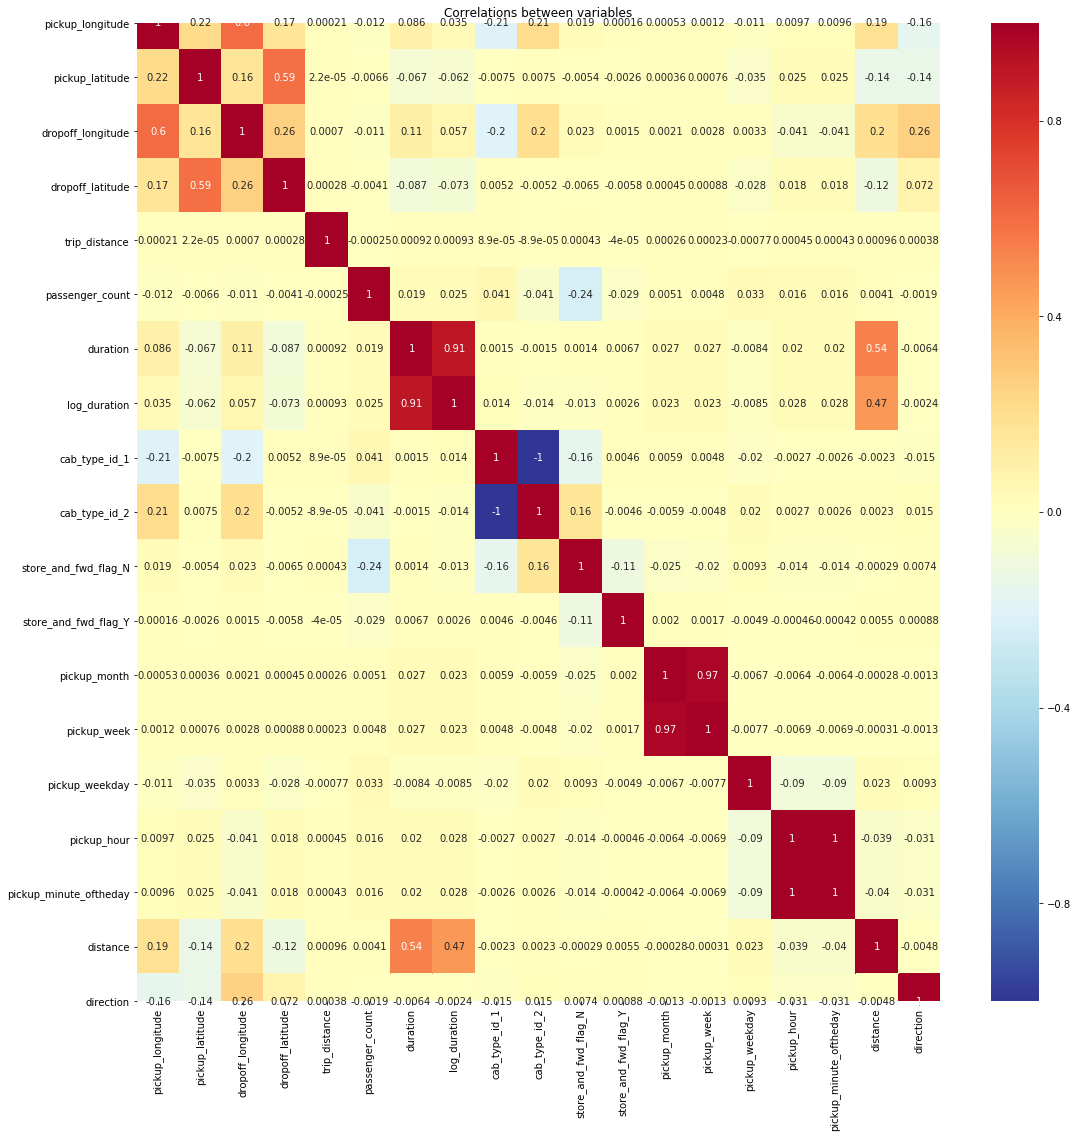

In [23]:
fig, ax = plt.subplots(figsize=(18,18))  
sns.heatmap(data=taxi_tran_drop.corr(), annot=True, cmap = plt.cm.RdYlBu_r, ax=ax).set_title('Correlations between variables');

#### save

In [24]:
X = taxi_tran_drop.drop(columns=['duration', 'log_duration'])
#y = taxi_tran_drop['duration']
y = taxi_tran_drop['log_duration']
X.to_hdf('data/case3/data.hdf5', key='X')
y.to_hdf('data/case3/data.hdf5', key='Y')

### Training


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm._tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [2]:
X = pd.read_hdf('data/case3/data.hdf5', key='X')
y = pd.read_hdf('data/case3/data.hdf5', key='Y')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=2019)

In [4]:
def train(reg, X_train, X_test, y_train, y_test, name):
    reger = reg.fit(X_train, y_train)
    print('%s R2 train: %.4f' % (name, reger.score(X_train, y_train)))
    print('%s R2 test: %.4f' % (name, reger.score(X_test, y_test)))
    print('%s rmse train: %.4f' % (name, np.sqrt(mean_squared_error(y_train, reger.predict(X_train)))))
    print('%s rmse test: %.4f' % (name, np.sqrt(mean_squared_error(y_test, reger.predict(X_test)))))
    #print('%s rmsle train: %.4f' % (name, np.sqrt(mean_squared_log_error(y_train, reger.predict(X_train)))))
    #print('%s rmsle train: %.4f' % (name, np.sqrt(mean_squared_log_error(y_test, reger.predict(X_test)))))
    

In [5]:
train(LinearRegression(), X_train, X_test, y_train, y_test, 'LinearRegression')

LinearRegression R2 train: 0.2254
LinearRegression R2 test: 0.2249
LinearRegression rmse train: 0.6098
LinearRegression rmse test: 0.6109


In [6]:
train(LassoCV(), X_train, X_test, y_train, y_test, 'Lasso')

/home/wpishare/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Lasso R2 train: 0.0659
Lasso R2 test: 0.0660
Lasso rmse train: 0.6696
Lasso rmse test: 0.6706


In [7]:
train(RidgeCV(), X_train, X_test, y_train, y_test, 'Ridge')

Ridge R2 train: 0.2254
Ridge R2 test: 0.2249
Ridge rmse train: 0.6098
Ridge rmse test: 0.6109


In [8]:
train(ElasticNetCV(), X_train, X_test, y_train, y_test, 'ElasticNet')

/home/wpishare/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNet R2 train: 0.0615
ElasticNet R2 test: 0.0617
ElasticNet rmse train: 0.6712
ElasticNet rmse test: 0.6722


In [9]:
train(GradientBoostingRegressor(), X_train, X_test, y_train, y_test, 'GradientBoosting')

GradientBoosting R2 train: 0.7565
GradientBoosting R2 test: 0.7575
GradientBoosting rmse train: 0.3419
GradientBoosting rmse test: 0.3417


In [10]:
train(RandomForestRegressor(n_jobs=-1), X_train, X_test, y_train, y_test, 'RandomForest')

/home/wpishare/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForest R2 train: 0.9633
RandomForest R2 test: 0.7953
RandomForest rmse train: 0.1327
RandomForest rmse test: 0.3140


In [11]:
train(LGBMRegressor(), X_train, X_test, y_train, y_test, 'LGBM')

LGBM R2 train: 0.7953
LGBM R2 test: 0.7952
LGBM rmse train: 0.3135
LGBM rmse test: 0.3141


In [6]:
num_leaves = [1300, 1500, 1800]
max_depth = [20, 25, 30]
learning_rate = [0.3, 0.1, 0.05]
feature_fraction = [0.8]
bagging_fraction = [0.5, 0.6, 0.7]
max_bin = [300, 400, 500, 600, 700]

random_grid = {'num_leaves': num_leaves,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'feature_fraction': feature_fraction,
               'bagging_fraction': bagging_fraction,
               'max_bin': max_bin}

lgbm = LGBMRegressor(objective='regression')
random_cv = RandomizedSearchCV(estimator=lgbm,
                               scoring='neg_mean_squared_error',
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=2019,
                               n_jobs = -1).fit(X_train, y_train)

print(random_cv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 98.3min
C:\Users\yangx\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 145.5min finished


{'num_leaves': 1800, 'max_depth': 25, 'max_bin': 700, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.7}


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.

In [7]:
lgbm = LGBMRegressor(**random_cv.best_params_)
train(lgbm, X_train, X_test, y_train, y_test, 'LGBM_beat_param')

LGBM_beat_param R2 train: 0.8574
LGBM_beat_param R2 test: 0.8293
LGBM_beat_param rmse train: 0.2616
LGBM_beat_param rmse test: 0.2867


*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 7 minutes' talk) to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 3".
        
**Note: Each team only needs to submit one submission in Canvas**


# Peer-Review Grading Template:

**Total Points: (100 points)** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) plot the spatial distribution of the pickup locations of 5000 Uber trips (10 points):
       0: missing answer
       4: okay, but with major problems
       7: good, but with minor problems
      10: perfect
    

    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect